# Chapter: Multivariate Statistical Process Monitoring for Linear and Dynamic Processes

# Topic:  DPCA model-based fault detection

In [1]:
# import required packages
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
# utility functions
def augment(X, n_lags):
    """ generate augumented matrix with n_lags lagged measurements for each feature
    
    Parameters:
    ---------------------
    X: ndarray of shape (n_samples, n_features)
        n_samples is the number of samples and n_features is the number of features.
    
    n_lags: The number of lags to be used for data augumentation.   
    
    
    Returns:
    ---------------------
    X_aug: ndarray of shape (n_samples-n_lags, (n_lags+1)*n_features).
    
    """
    
    # augment training data
    N, m = X.shape
    X_aug = np.zeros((N-n_lags, (n_lags+1)*m))
    
    for sample in range(n_lags, N):
        XBlock = X[sample-n_lags:sample+1,:]
        X_aug[sample-n_lags,:] = np.reshape(XBlock, (1,-1), order = 'F')
        
    return X_aug

In [3]:
# read data
X_NOC = np.loadtxt('multivariate_NOC_data.txt')
X_test = np.loadtxt('multivariate_test_data.txt')

Number of PCs cumulatively explaining atleast 95% variance:  4


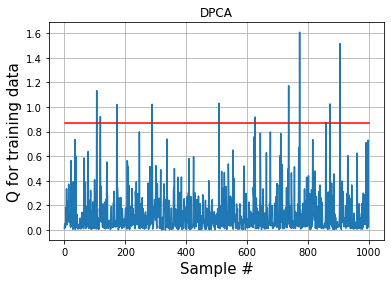

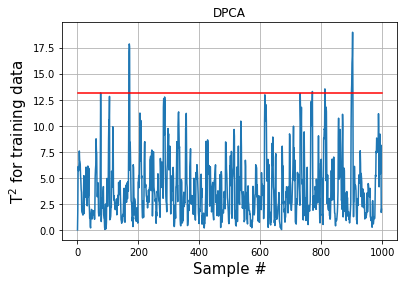

In [5]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                        DPCA model training
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# augment and scale data
X_NOC_aug = augment(X_NOC, 1)
scaler = StandardScaler()
X_NOC_aug_scaled = scaler.fit_transform(X_NOC_aug)

# fit PCA model
dpca = PCA().fit(X_NOC_aug_scaled)

# find n_component
explained_variance = 100*dpca.explained_variance_ratio_ # in percentage
cum_explained_variance = np.cumsum(explained_variance) # cumulative % variance explained
n_comp = np.argmax(cum_explained_variance >= 95) + 1    
print('Number of PCs cumulatively explaining atleast 95% variance: ', n_comp)

# refit with n_comp
dpca = PCA(n_components=n_comp)
dpca.fit(X_NOC_aug_scaled)

# compute scores and error for training data
scores_NOC = dpca.transform(X_NOC_aug_scaled)
X_NOC_aug_scaled_reconstruct = dpca.inverse_transform(scores_NOC)
error_NOC = X_NOC_aug_scaled - X_NOC_aug_scaled_reconstruct

# calculate Q for training data
Q_NOC = np.sum(error_NOC*error_NOC, axis = 1)

# calculate T2 for training data
N = X_NOC_aug_scaled.shape[0]

lambda_k = np.diag(dpca.explained_variance_) # eigenvalue = explained variance
lambda_k_inv = np.linalg.inv(lambda_k)

T2_NOC = np.zeros((N,))
for i in range(N):
    T2_NOC[i] = np.dot(np.dot(scores_NOC[i,:], lambda_k_inv), scores_NOC[i,:].T)

# control limits
Q_CL = np.percentile(Q_NOC, 99)
T2_CL = np.percentile(T2_NOC, 99)

# monitoring charts for NOC/training data
plt.figure(), plt.plot(Q_NOC), plt.plot([1,len(Q_NOC)],[Q_CL,Q_CL], color='red')
plt.xlabel('Sample #', fontsize=15), plt.ylabel('Q for training data', fontsize=15), plt.title('DPCA')
plt.grid()
           
plt.figure(), plt.plot(T2_NOC), plt.plot([1,len(T2_NOC)],[T2_CL,T2_CL], color='red')
plt.xlabel('Sample #', fontsize=15), plt.ylabel('T$^2$ for training data', fontsize=15), plt.title('DPCA')
plt.grid()

plt.show()

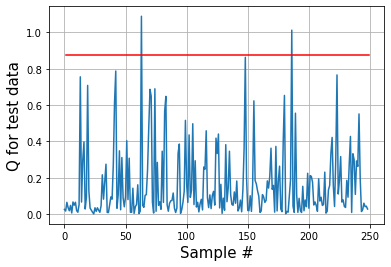

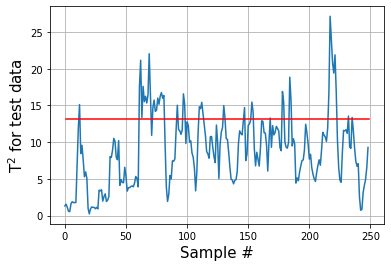

In [6]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                    Monitoring charts for test data
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# augment and scale test data
X_test_aug = augment(X_test, 1)
X_aug_test_scaled = scaler.transform(X_test_aug)

# compute scores and error for test data
scores_test = dpca.transform(X_aug_test_scaled)
X_aug_test_scaled_reconstruct = dpca.inverse_transform(scores_test)
error_test = X_aug_test_scaled - X_aug_test_scaled_reconstruct

# calculate Q and T2 for test data
Q_test = np.sum(error_test*error_test, axis = 1)

N_test = X_aug_test_scaled.shape[0]
T2_test = np.zeros((N_test,))
for i in range(N_test):
    T2_test[i] = np.dot(np.dot(scores_test[i,:], lambda_k_inv), scores_test[i,:].T)

# monitoring charts for test data
plt.figure(), plt.plot(Q_test), plt.plot([1,len(Q_test)],[Q_CL,Q_CL], color='red')
plt.xlabel('Sample #', fontsize=15), plt.ylabel('Q for test data', fontsize=15), plt.grid()
           
plt.figure(), plt.plot(T2_test), plt.plot([1,len(T2_test)],[T2_CL,T2_CL], color='red')
plt.xlabel('Sample #', fontsize=15), plt.ylabel('T$^2$ for test data', fontsize=15), plt.grid()

plt.show()